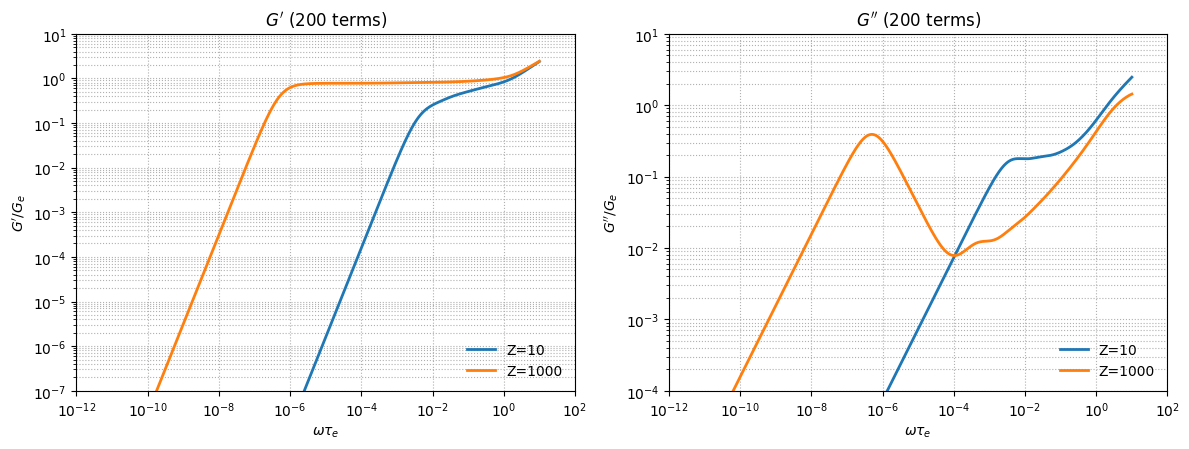

In [ ]:
# -*- coding: utf-8 -*-
# LM(2002) -> generalized Maxwell (Prony) -> G', G'' and CSV export
# 入力: 同じフォルダに "Z_input.txt" を置き、1行目・2行目に Z を書く（例: 10\n1000）
# 出力: 各 Z について "Z{Z}.csv" を保存（列: omega, Gp, Gpp）

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from scipy.special import gamma, gammaincc
import os

# 保存時
np.savetxt(os.path.join(outdir, f"Z{int(Z)}.csv"), out, delimiter=",",
           header="omega_tau_e,Gp_over_Ge,Gpp_over_Ge", comments="")


# ---------- LM(2002) constants ----------
C1, C2, C3 = 1.69, 4.17, -1.55
CR, Cv     = 1.8, 1.0

# ---------- small helpers ----------
def tau_d_over_taue(Z):
    return 3.0 * Z**3 * (1 - 2*C1/np.sqrt(Z) + C2/Z + C3/Z**1.5)

def G_f(Z):
    return 1.0 - C1/np.sqrt(Z) + 2.0/Z - 1.24/Z**1.5

def pstar(Z):
    ps = int(np.floor(np.sqrt(Z/10.0)))
    if ps < 1: ps = 1
    if ps % 2 == 0: ps -= 1
    return ps

def eps_star(Z, coef1, sum1):
    return (1.0/Z**4) * (4.0*0.306 / (1.0 - coef1*sum1))**4

# upper incomplete gamma Γ(s,x)
def Gamma_upper(s, x):  # s>0
    return gamma(s) * gammaincc(s, x)

# Γ(-1/4, x) via recurrence
def Gamma_upper_m14(x):
    return -4.0 * (Gamma_upper(0.75, x) - x**(-0.25) * np.exp(-x))

# ---------- μ(t̂) ----------
def mu_hat_only(t_hat, Z):
    t_hat = np.atleast_1d(t_hat).astype(float)
    td    = tau_d_over_taue(Z)
    coef1 = (8.0/np.pi**2) * G_f(Z)
    ps    = pstar(Z)
    p     = np.arange(1, ps+1, 2.0)
    invp2 = 1.0/(p**2)
    rept  = coef1 * np.sum(invp2[None,:] * np.exp(-t_hat[:,None]*(p**2)/td), axis=1)
    s1 = np.sum(invp2)
    es = eps_star(Z, coef1, s1)
    x  = es * t_hat
    tail = (t_hat**0.25) * Gamma_upper_m14(x)
    return rept + (0.306/Z) * tail

# ---------- R(t̂) ----------
def R_of_t(t_hat, Z):
    t_hat = np.atleast_1d(t_hat).astype(float)
    return 1.0 - (CR/Z) * (Cv * t_hat)**0.25

# ---------- LM eq.(19): G(t)/Ge ----------
def G_time_LM(t_hat, Z, Pmax2=5000):
    t_hat = np.atleast_1d(t_hat).astype(float)
    mu = mu_hat_only(t_hat, Z)
    G_tube = (4.0/5.0) * (mu * R_of_t(t_hat, Z))
    x = t_hat/(Z**2)
    if Z > 1:
        p1 = np.arange(1, Z, 1.0)
        G1 = (1.0/(5.0*Z)) * np.exp(-(p1**2)[None,:] * x[:,None]).sum(axis=1)
    else:
        G1 = np.zeros_like(t_hat)
    p2 = np.arange(Z, Pmax2, 1.0)
    G2 = (1.0/Z) * np.exp(-(2.0*(p2**2))[None,:] * x[:,None]).sum(axis=1)
    return G_tube + G1 + G2   # already normalized by Ge

# ---------- Fit G(t) with generalized Maxwell (NNLS) ----------
def fit_maxwell(Gt_t, t, n_terms=100):
    """
    Fit G(t) ≈ Σ_j G_j exp(-t/τ_j) with fixed log-spaced τ_j (NNLS).
    Returns taus [n_terms], Gp [n_terms].
    """
    t = np.asarray(t, float)
    tmin, tmax = t.min(), t.max()
    taus = np.geomspace(tmin/20, tmax*20, n_terms)  #少し広め
    E = np.exp(-t[:, None] / taus[None, :])
    Gp = nnls(E, np.asarray(Gt_t, float))[0]        # 非負制約
    return taus, Gp

# ---------- Compute G', G'' from (Gp, taus) ----------
def storage_loss_from_prony(omega, taus, Gp):
    x = np.outer(omega, taus)  # [M x P]
    denom = 1.0 + x**2
    Gprime  = (Gp[None, :] * (x**2) / denom).sum(axis=1)
    Gloss   = (Gp[None, :] * (x)    / denom).sum(axis=1)
    return Gprime, Gloss

# ---------- read Z from first two lines of a text file ----------
def load_Z_list(path="Z_input.txt", maxn=2):
    if not os.path.exists(path):
        # フォールバック: サンプル
        return [10, 1000]
    vals = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            try:
                vals.append(int(float(s)))
            except ValueError:
                pass
            if len(vals) >= maxn:
                break
    return vals

# ===================== Main =====================
if __name__ == "__main__":
    # Z は "Z_input.txt" の 1行目・2行目から読む（存在しなければ [10,1000]）
    Z_list = load_Z_list("Z_input.txt", maxn=2)

    # grids
    t_hat  = np.geomspace(1e-10, 1e5, 1500)   # t/τe
    omega  = np.geomspace(1e-12, 1e1, 1300)    # ωτe
    n_terms = 200                              # Prony 項数

    # プロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.6))

    for Z in Z_list:
        Gt = G_time_LM(t_hat, Z, Pmax2=5000)
        taus, Gp_coeff = fit_maxwell(Gt, t_hat, n_terms=n_terms)
        Gp_w, Gpp_w = storage_loss_from_prony(omega, taus, Gp_coeff)

        # --- CSV 出力（w, G', G''）---
        out = np.column_stack([omega, Gp_w, Gpp_w])
        np.savetxt(f"Z{int(Z)}.csv", out, delimiter=",",
                   header="omega_tau_e,Gp_over_Ge,Gpp_over_Ge", comments="")
        # プロット
        ax1.loglog(omega, Gp_w, lw=2.0, label=f"Z={int(Z)}")
        ax2.loglog(omega, Gpp_w, lw=2.0, label=f"Z={int(Z)}")

    ax1.set_xlim(1e-12, 1e2); ax1.set_ylim(1e-7, 1e1)
    ax1.set_xlabel(r'$\omega \tau_e$'); ax1.set_ylabel(r"$G'/G_e$")
    ax1.set_title(r"$G'$ ({} terms)".format(n_terms)); ax1.grid(True, which='both', ls=':')
    ax1.legend(loc='lower right', fontsize=10, frameon=False)

    ax2.set_xlim(1e-12, 1e2); ax2.set_ylim(1e-4, 1e1)
    ax2.set_xlabel(r'$\omega \tau_e$'); ax2.set_ylabel(r"$G''/G_e$")
    ax2.set_title(r"$G''$ ({} terms)".format(n_terms)); ax2.grid(True, which='both', ls=':')
    ax2.legend(loc='lower right', fontsize=10, frameon=False)

    plt.tight_layout()
    plt.show()
